# ADS-B API

The [Contrails API](https://api.contrails.org) enables authorized users to access a common ADS-B dataset for contrails research. 

The underlying ADS-B data is provided by [Spire Aviation](https://aviation-docs.spire.com/).

E-mail [api@contrails.org](mailto:api@contrails.org?subject=Common%20ADS-B%20Access) with subject **Common ADS-B Access** to learn more about how your organization can participate in this program.

In [1]:
import os

In [2]:
# Load API key
# (contact api@contrails.org if you need an API key)
URL = "https://api.contrails.org"
API_KEY = os.environ["CONTRAILS_API_KEY"]
HEADERS = {"x-api-key": API_KEY}

## Telemetry

**GET [/v1/adsb/telemetry](https://api.contrails.org/openapi#/ADS-B/get_telemetry_v1_adsb_telemetry_get)**

> Note this endpoint can take up to 30 seconds to return depending on bandwidth

This endpoint returns 1 hour range of all global ADS-B telemetry data as an [Apache Parquet](https://parquet.apache.org/) file.

Input date must be an ISO 8601 datetime string (UTC) with hourly resolution, e.g. `"2025-01-06T00"`. 
Any minute or second resolution is ignored.

See the [ADS-B schema](https://apidocs.contrails.org/_static/adsb-schema.json) for the description of each data key in the Parquet file.

In [3]:
import requests  # pip install requests
import matplotlib.pyplot as plt  # pip install matplotlib
import pandas as pd  # pip install pandas

### Get data for a single hour

In [4]:
params = {
    "date": "2025-01-24T02"  # ISO 8601 (UTC)
}

r = requests.get(f"{URL}/v1/adsb/telemetry", params=params, headers=HEADERS)
print(f"HTTP Response Code: {r.status_code} {r.reason}\n")

# write out response content as parquet file
with open(f"{params['date']}.pq", "wb") as f:
    f.write(r.content)

HTTP Response Code: 200 OK



In [5]:
# read parquet file with pandas
df = pd.read_parquet(f"{params['date']}.pq")

print("Number of unique flights:", df["flight_id"].nunique())
print("Number of unique waypoints:", len(df["flight_id"]))

df.head()

Number of unique flights: 17103
Number of unique waypoints: 1093322


timestamp   latitude   longitude collection_type  altitude_baro  \
0 2025-01-24 02:59:59  37.882629  -80.429001     terrestrial          31000   
1 2025-01-24 02:59:59  36.193588 -112.395912     terrestrial          35000   
2 2025-01-24 02:59:59 -44.230362  171.841019     terrestrial          33950   
3 2025-01-24 02:59:59  43.008354   26.135494     terrestrial          38000   
4 2025-01-24 02:59:59  28.975525 -109.411362     terrestrial          37000   

  icao_address                             flight_id callsign tail_number  \
0       A91986  93a5cd24-1e7b-4dca-a07d-ad391a2e8237  PDT5701      N686AE   
1       AB415E  d1dfe570-9e39-4323-a6cf-f4cf602b4149   SCX618      N824SY   
2       C81D8E  12d6d993-c01e-4553-80e1-944a34119f69   ANZ689      ZK-OAB   
3       4B187F  0e7d48c3-a4e2-4489-aaa3-4c9b9bea05c2   SWR155      HB-JHF   
4       0D09D5  b4050af1-1fc8-4997-ac5a-1d46b690c869  VOI1743      XA-VLU   

  flight_number aircraft_type_icao airline_iata departure_airport_icao  \
0        AA5701               E145           PT                   KCLT   
1         SY618               B738           SY                   KPSP   
2         NZ689               A320           NZ                   NZWN   
3         LX155               A333           LX                   VABB   
4        Y41743               A321           Y4                   KLAS   

  departure_scheduled_time arrival_airport_icao arrival_scheduled_time  
0      2025-01-24 01:53:00                 KERI    2025-01-24 03:48:00  
1      2025-01-24 02:24:00                 KMSP    2025-01-24 05:41:00  
2      2025-01-24 02:05:00                 NZDN    2025-01-24 03:25:00  
3      2025-01-23 19:50:00                 LSZH    2025-01-24 05:10:00  
4      2025-01-24 01:31:00                 MMGL    2025-01-24 04:43:00

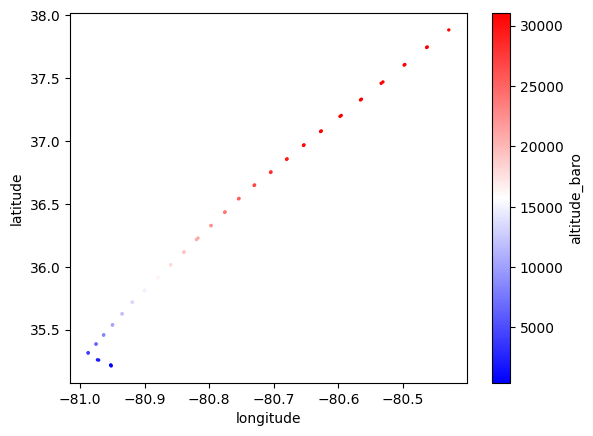

In [6]:
# select single flight and plot
flight_id = df.iloc[0]["flight_id"]
flight = df.loc[df["flight_id"] == flight_id]
flight.plot.scatter(x="longitude", y="latitude", c="altitude_baro", cmap="bwr", s=2);

### Aggregate data over multiple hours

In [7]:
start = "2025-01-15T02"
end = "2025-01-15T03"
times = pd.date_range(start=start, end=end, freq="h")
times_str = [t.strftime("%Y-%m-%dT%H") for t in times]

In [8]:
for t in times_str:
    print(f"Downloading hour: {t}")

    r = requests.get(f"{URL}/v1/adsb/telemetry", params={"date": t}, headers=HEADERS)
    print(f"HTTP Response Code: {r.status_code} {r.reason}\n")

    # write out response content as parquet file
    with open(f"{t}.pq", "wb") as f:
        f.write(r.content)

HTTP Response Code: 200 OK

HTTP Response Code: 200 OK



In [9]:
dfs = []
for t in times_str:
    dfs.append(pd.read_parquet(f"{t}.pq"))

df = pd.concat(dfs)

print("Number of unique flights:", df["flight_id"].nunique())
print("Number of unique waypoints:", len(df["flight_id"]))

Number of unique flights: 21240
Number of unique waypoints: 1944787


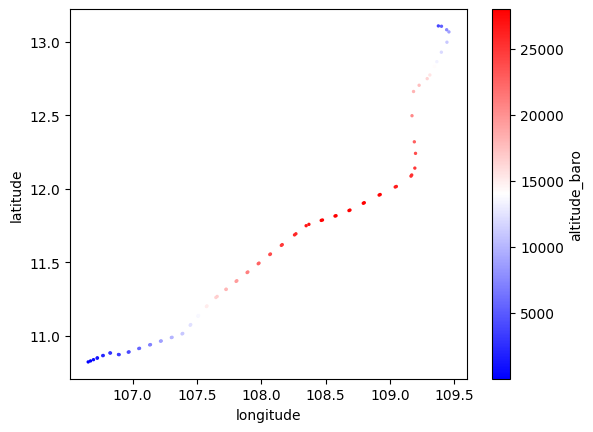

In [10]:
# select single flight and plot
flight_id = df.iloc[0]["flight_id"]
flight = df.loc[df["flight_id"] == flight_id]
flight.plot.scatter(x="longitude", y="latitude", c="altitude_baro", cmap="bwr", s=2);

## Bulk Load ADS-B into external datastore

> This section requires a fresh notebook kernel.
> Restart the kernel if you have already run the section above.

This section will provide a tutorial that covers:

- Fetching a range of ADS-B data from the Contrails API
- Loading those data into an external database/datastore

This tutorial will focus on loading data into a [Google BigQuery table](https://cloud.google.com/bigquery).
The same approach can be adapted to load these data into other database / datastores.

This process is useful if you want to perform advanced queries on the dataset.

### Prerequisites

You must have a [Google Cloud account](https://cloud.google.com/), and the [Google Cloud CLI](https://cloud.google.com/sdk/docs/install) (`gcloud`) installed on your machine.

You must also have set up a [BigQuery table](https://console.cloud.google.com/bigquery) and given your account [the required permissions](https://cloud.google.com/bigquery/docs/loading-data-cloud-storage-parquet#required_permissions) to load data into this table.

In [1]:
import json
import os
from pathlib import Path

# NOTE: grequests *must* be imported before requests, or you will see a MonekyPatchWarning
import grequests  # pip install grequests (for parallel REST requests)
import pandas as pd  # pip install pandas

from google.cloud import bigquery  # pip install google-cloud-bigquery
from google.cloud.bigquery import LoadJobConfig

In [2]:
# Load API key
URL = "https://api.contrails.org"
API_KEY = os.environ["CONTRAILS_API_KEY"]
HEADERS = {"x-api-key": API_KEY}

### Download ADS-B data files to your machine

Set target hours for ADS-B data, then fetch ADS-B data from the Contrails API in a parallel, saving parquet files to the local machine.

In [3]:
# 6 hours of data
start = "2025-01-16T00"
end = "2025-01-16T06"
times = pd.date_range(start=start, end=end, freq="h")
times_str = [t.strftime("%Y-%m-%dT%H") for t in times]

In [4]:
# Use `grequests` to send out parallel API requests
# (this cell can take minutes to evaluate depending on bandwidth)
req = (
    grequests.get(f"{URL}/v1/adsb/telemetry", params={"date": t}, headers=HEADERS)
    for t in times_str
)
responses = grequests.map(req, size=25)

# create local directory to store local parquet files
os.makedirs("adsb", exist_ok=True)

# Write out each hour as a parquet file in subdirectory `adsb`
for t, r in zip(times_str, responses):
    print(f"{t}: {r.status_code} {r.reason}")

    # write out response content as parquet file
    path = Path(f"adsb/{t}.pq")
    with open(path, "wb") as f:
        f.write(r.content)

2025-01-16T00: 200 OK
2025-01-16T01: 200 OK
2025-01-16T02: 200 OK
2025-01-16T03: 200 OK
2025-01-16T04: 200 OK
2025-01-16T05: 200 OK
2025-01-16T06: 200 OK


### (Optional) Create the target BigQuery table

If a target BigQuery table does not exist, then create one prior to inserting the target data.

The table must have a schema compatible with the fields present in the parquet ADS-B data.

You can create a table using the `bq mk` command (`bq` comes bundled with the `gcloud` CLI).

```bash
bq mk --table project_id:dataset_id.table_id adsb-schema.json
```

- `project_id` is the GCP project ID for your account.
- `dataset_id` is the BigQuery dataset where you want to create a new table.

> If the dataset does not already exist, you will have to create it first with the 
> [`bq mk --dataset` command](https://cloud.google.com/bigquery/docs/datasets#bq) 
> (or via the web Console...)

- `table_id` is the table name for the new table you are creating.
- `adsb-schema.json` is the filepath to a local JSON file with the schema definition for the new table. Download the [ADS-B schema](https://apidocs.contrails.org/_static/adsb-schema.json) provided in the documentation - this schema is compatible with the BigQuery API

```bash
curl -X GET https://apidocs.contrails.org/_static/adsb-schema.json > adsb-schema.json
```

In [5]:
# !bq mk --table project_id:dataset_id.table_id adsb-schema.json

### Load data into a BigQuery table

Assuming you have an empty BigQuery table created, the following loads local data into the BigQuery table on file at a time.

> **PRO TIP**
> 
> To maximize BigQuery load speed, 
> consider moving the dataset into a Google Cloud Storage Bucket.
>
> See [client.load_table_from_uri(..)](https://cloud.google.com/python/docs/reference/bigquery/latest/google.cloud.bigquery.client.Client#google_cloud_bigquery_client_Client_load_table_from_uri) or the [`bq load` command](https://cloud.google.com/bigquery/docs/batch-loading-data#permissions-load-data-from-cloud-storage).
> 
> Uploading from a GCS bucket will increase upload speed both due to 
> the bucket being in the Google network (high uplink speed), and the commands above supporting wildcards for GCS URI paths.

In [6]:
# Initialize BigQuery client
client = bigquery.Client()  # Uses your default GCP "project" - see `gcloud config list`

# Create table reference
project_id = "<project_id>"  # REPLACE WITH YOUR GCP PROJECT
dataset_id = "<dataset_id>"  # REPLACE WITH YOUR BQ DATASET
table_id = "<table_id>"  # REPLACE WITH YOUR BQ TABLE
bigquery_id = f"{project_id}.{dataset_id}.{table_id}"

# Load schema
with open("adsb-schema.json", "r") as f:
    schema = json.load(f)

# Configure the loading job
job_config = LoadJobConfig(source_format=bigquery.SourceFormat.PARQUET, schema=schema)

for t in times_str:
    # read in parquet file
    path = Path(f"adsb/{t}.pq")
    print(f"Loading {t}")

    # Open the local parquet file
    with open(path, "rb") as f:
        # Start the load job
        load_job = client.load_table_from_file(f, bigquery_id, job_config=job_config)

    # Wait for job completion
    load_job.result()

    print(f"Loaded {load_job.output_rows} rows into {bigquery_id}")

Loading 2025-01-16T00
Loaded 1158825 rows into contrails-301217.sandbox.adsb3
Loading 2025-01-16T01
Loaded 1197240 rows into contrails-301217.sandbox.adsb3
Loading 2025-01-16T02
Loaded 1111672 rows into contrails-301217.sandbox.adsb3
Loading 2025-01-16T03
Loaded 966330 rows into contrails-301217.sandbox.adsb3
Loading 2025-01-16T04
Loaded 895878 rows into contrails-301217.sandbox.adsb3
Loading 2025-01-16T05
Loaded 736327 rows into contrails-301217.sandbox.adsb3
Loading 2025-01-16T06
Loaded 601999 rows into contrails-301217.sandbox.adsb3
